In [3]:
import sys
!{sys.executable} -m pip install seaborn

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, ttest_ind

In [7]:
import os
os.makedirs("figures", exist_ok=True)

In [9]:
df_healthy = pd.read_csv("healthy_groupsim_results/healthy_groupsim_metrics.csv")
df_mild_tbi = pd.read_csv("tbi_mildgroup_results/tbi_mild_group_metrics.csv")
df_strong_tbi = pd.read_csv("tbi_stronggroup_results/tbi_strong_group_metrics.csv")
df_tdcs_mild = pd.read_csv("tdcs_mildgroup_results/tdcs_mildgroup_metrics.csv")
df_tdcs_strong = pd.read_csv("tdcs_stronggroup_results/tdcs_group_metrics.csv")

In [11]:
df_healthy["group"] = "healthy"
df_mild_tbi["group"] = "mild_tbi"
df_strong_tbi["group"] = "severe_tbi"
df_tdcs_mild["group"] = "tdcs_mild_tbi"
df_tdcs_strong["group"] = "tdcs_severe_tbi"

df_all = pd.concat([df_healthy, df_mild_tbi, df_strong_tbi, df_tdcs_mild, df_tdcs_strong], ignore_index=True)

In [13]:
def run_anova(metric):
    groups = df_all['group'].unique()
    samples = [df_all[df_all['group'] == g][metric] for g in groups]
    f_val, p_val = f_oneway(*samples)
    print(f"{metric}: F = {f_val:.2f}, p = {p_val:.4f}")

print("=== ANOVA RESULTS ===")
run_anova("alpha_power_dlpfc")
run_anova("mean_fc_strength")

=== ANOVA RESULTS ===
alpha_power_dlpfc: F = 4.52, p = 0.0015
mean_fc_strength: F = 1.57, p = 0.1817


In [15]:
def posthoc_ttests(metric):
    groups = df_all['group'].unique()
    print(f"\nPost-hoc t-tests for {metric}:")
    for i, g1 in enumerate(groups):
        for g2 in groups[i+1:]:
            t, p = ttest_ind(df_all[df_all['group'] == g1][metric],
                             df_all[df_all['group'] == g2][metric],
                             equal_var=False)
            print(f"{g1} vs {g2}: t = {t:.2f}, p = {p:.4f}")

posthoc_ttests("alpha_power_dlpfc")
posthoc_ttests("mean_fc_strength")


Post-hoc t-tests for alpha_power_dlpfc:
healthy vs mild_tbi: t = -0.19, p = 0.8528
healthy vs severe_tbi: t = 2.92, p = 0.0044
healthy vs tdcs_mild_tbi: t = -1.13, p = 0.2602
healthy vs tdcs_severe_tbi: t = -1.54, p = 0.1274
mild_tbi vs severe_tbi: t = 2.78, p = 0.0067
mild_tbi vs tdcs_mild_tbi: t = -0.88, p = 0.3784
mild_tbi vs tdcs_severe_tbi: t = -1.26, p = 0.2104
severe_tbi vs tdcs_mild_tbi: t = -3.68, p = 0.0004
severe_tbi vs tdcs_severe_tbi: t = -4.12, p = 0.0001
tdcs_mild_tbi vs tdcs_severe_tbi: t = -0.36, p = 0.7172

Post-hoc t-tests for mean_fc_strength:
healthy vs mild_tbi: t = 0.10, p = 0.9214
healthy vs severe_tbi: t = 1.39, p = 0.1664
healthy vs tdcs_mild_tbi: t = -0.23, p = 0.8148
healthy vs tdcs_severe_tbi: t = 1.67, p = 0.0980
mild_tbi vs severe_tbi: t = 1.33, p = 0.1851
mild_tbi vs tdcs_mild_tbi: t = -0.34, p = 0.7331
mild_tbi vs tdcs_severe_tbi: t = 1.62, p = 0.1086
severe_tbi vs tdcs_mild_tbi: t = -1.66, p = 0.1001
severe_tbi vs tdcs_severe_tbi: t = 0.29, p = 0.7703

In [17]:
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_std = np.sqrt(((nx - 1)*np.var(x, ddof=1) + (ny - 1)*np.var(y, ddof=1)) / (nx + ny - 2))
    return (np.mean(x) - np.mean(y)) / pooled_std

In [19]:
def print_cohens_d(metric):
    print(f"\nCohen’s d for {metric}:")
    pairs = [
        ("healthy", "mild_tbi"),
        ("healthy", "severe_tbi"),
        ("mild_tbi", "tdcs_mild_tbi"),
        ("severe_tbi", "tdcs_severe_tbi"),
        ("healthy", "tdcs_mild_tbi"),
        ("healthy", "tdcs_severe_tbi"),
    ]
    for g1, g2 in pairs:
        d = cohens_d(df_all[df_all['group'] == g1][metric],
                     df_all[df_all['group'] == g2][metric])
        print(f"{g1} vs {g2}: d = {d:.2f}")

print_cohens_d("alpha_power_dlpfc")
print_cohens_d("mean_fc_strength")


Cohen’s d for alpha_power_dlpfc:
healthy vs mild_tbi: d = -0.04
healthy vs severe_tbi: d = 0.58
mild_tbi vs tdcs_mild_tbi: d = -0.18
severe_tbi vs tdcs_severe_tbi: d = -0.82
healthy vs tdcs_mild_tbi: d = -0.23
healthy vs tdcs_severe_tbi: d = -0.31

Cohen’s d for mean_fc_strength:
healthy vs mild_tbi: d = 0.02
healthy vs severe_tbi: d = 0.28
mild_tbi vs tdcs_mild_tbi: d = -0.07
severe_tbi vs tdcs_severe_tbi: d = 0.06
healthy vs tdcs_mild_tbi: d = -0.05
healthy vs tdcs_severe_tbi: d = 0.33


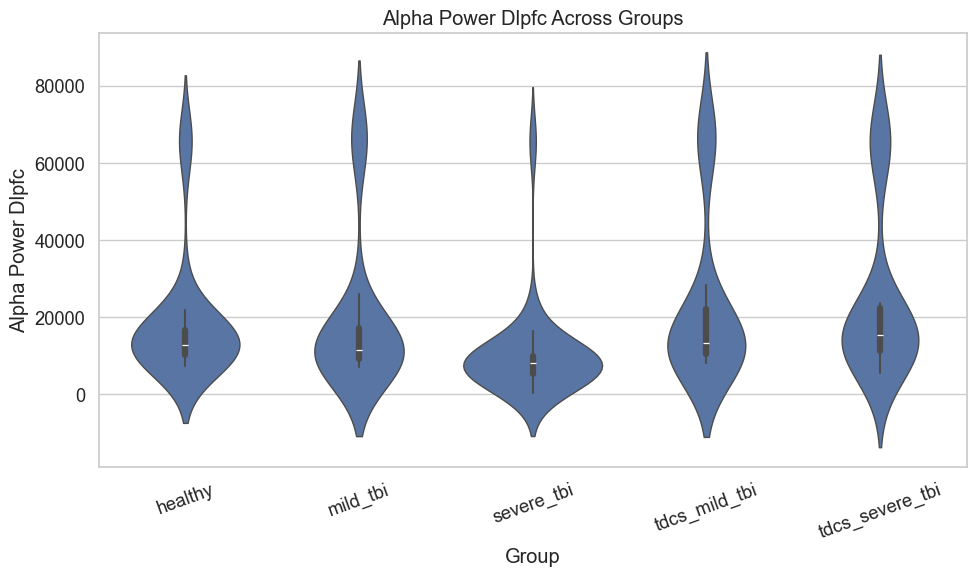

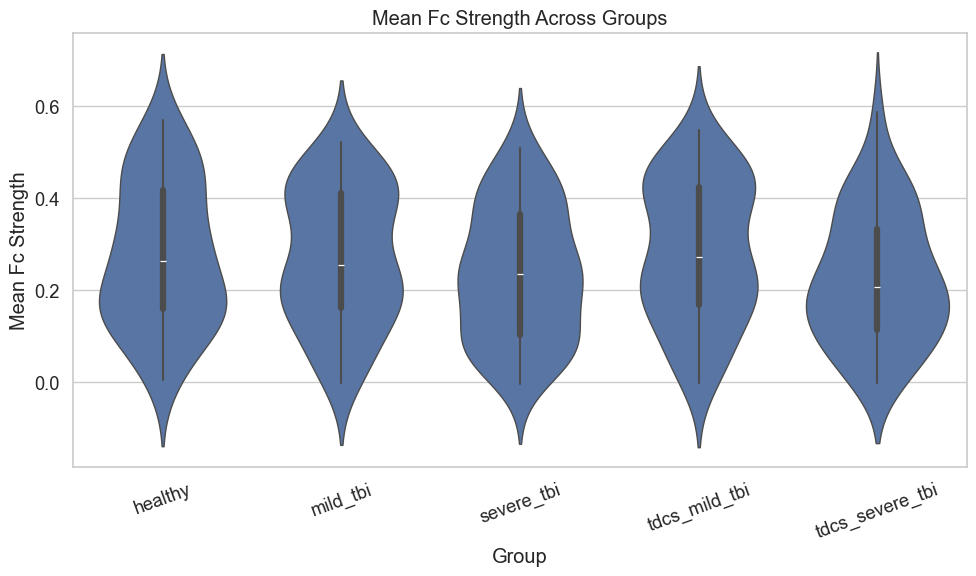

In [21]:
sns.set(style="whitegrid", font_scale=1.2)

for metric in ["alpha_power_dlpfc", "mean_fc_strength"]:
    plt.figure(figsize=(10, 6))
    sns.violinplot(x="group", y=metric, data=df_all, inner="box", linewidth=1)
    plt.title(f"{metric.replace('_', ' ').title()} Across Groups")
    plt.ylabel(metric.replace("_", " ").title())
    plt.xlabel("Group")
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.savefig(f"figures/{metric}_violin.png", dpi=300, bbox_inches='tight')
    plt.show()

In [23]:
import pandas as pd

data = {
    "Comparison": [
        "Healthy vs Mild TBI",
        "Healthy vs Severe TBI",
        "Healthy vs tDCS Mild TBI",
        "Healthy vs tDCS Severe TBI",
        "Mild TBI vs Severe TBI",
        "Mild TBI vs tDCS Mild TBI",
        "Mild TBI vs tDCS Severe TBI",
        "Severe TBI vs tDCS Mild TBI",
        "Severe TBI vs tDCS Severe TBI",
        "tDCS Mild TBI vs Severe TBI",
    ],
    "Alpha Power (p)": [
        0.8528, 0.0044, 0.2602, 0.1274, 0.0067, 0.3784, 0.2104, 0.0004, 0.0001, 0.7172
    ],
    "Mean FC Strength (p)": [
        0.9214, 0.1664, 0.8148, 0.0980, 0.1851, 0.7331, 0.1086, 0.1001, 0.7703, 0.0553
    ]
}

df_results = pd.DataFrame(data)

print(df_results)

                      Comparison  Alpha Power (p)  Mean FC Strength (p)
0            Healthy vs Mild TBI           0.8528                0.9214
1          Healthy vs Severe TBI           0.0044                0.1664
2       Healthy vs tDCS Mild TBI           0.2602                0.8148
3     Healthy vs tDCS Severe TBI           0.1274                0.0980
4         Mild TBI vs Severe TBI           0.0067                0.1851
5      Mild TBI vs tDCS Mild TBI           0.3784                0.7331
6    Mild TBI vs tDCS Severe TBI           0.2104                0.1086
7    Severe TBI vs tDCS Mild TBI           0.0004                0.1001
8  Severe TBI vs tDCS Severe TBI           0.0001                0.7703
9    tDCS Mild TBI vs Severe TBI           0.7172                0.0553
